In [1]:
from utils import *
from constants import *
import numpy as np
from datetime import datetime
import json
import os, shutil
import csv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
# plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
# sns.set(font=['sans-serif'])
# sns.set_style("whitegrid", {"font.sans-serif":['simhei']})


0 8760
year: 2014


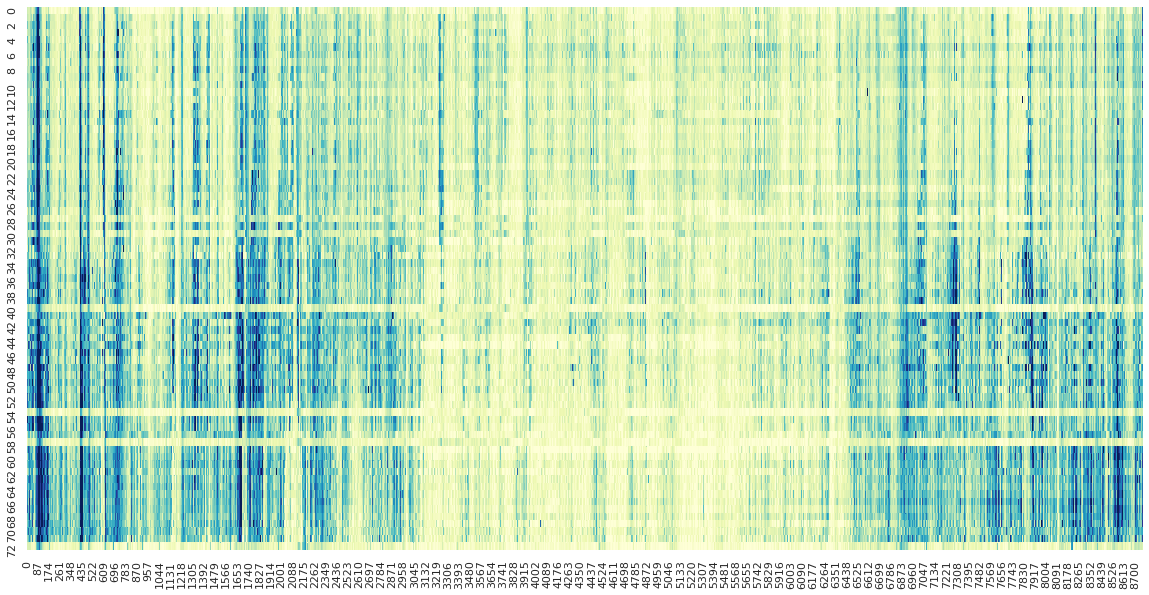

8760 17520
year: 2015


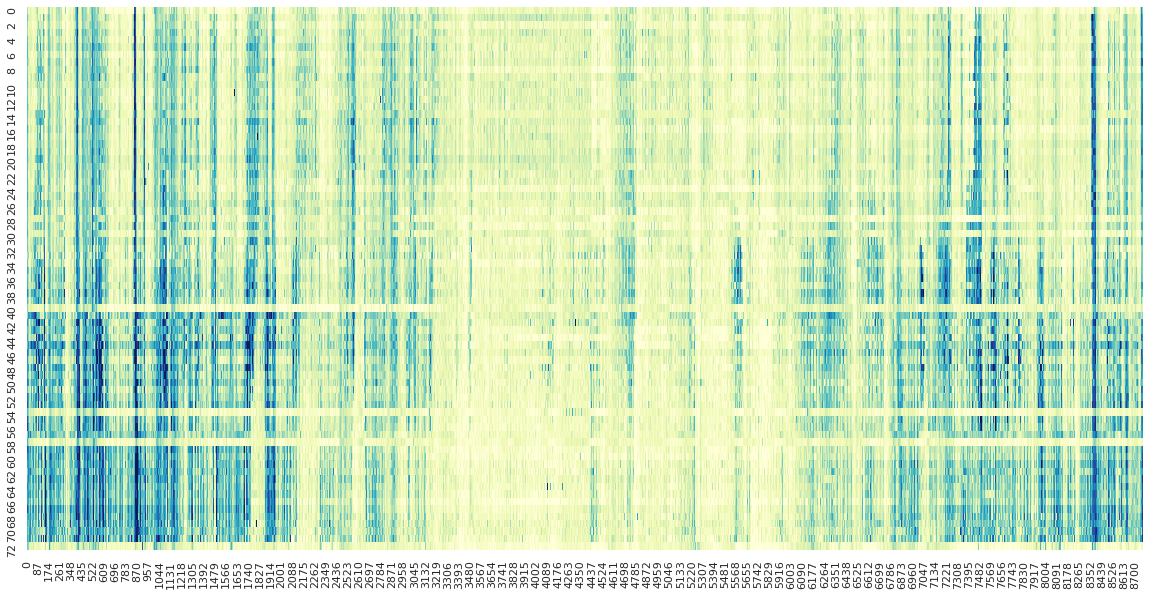

17520 26280
year: 2016


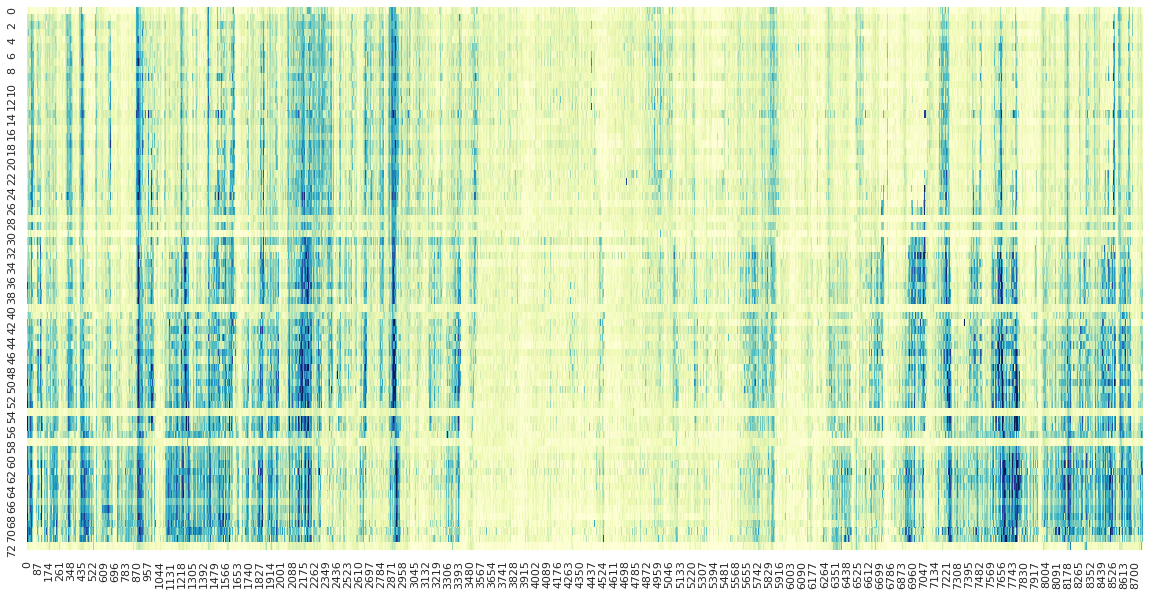

26280 35040
year: 2017


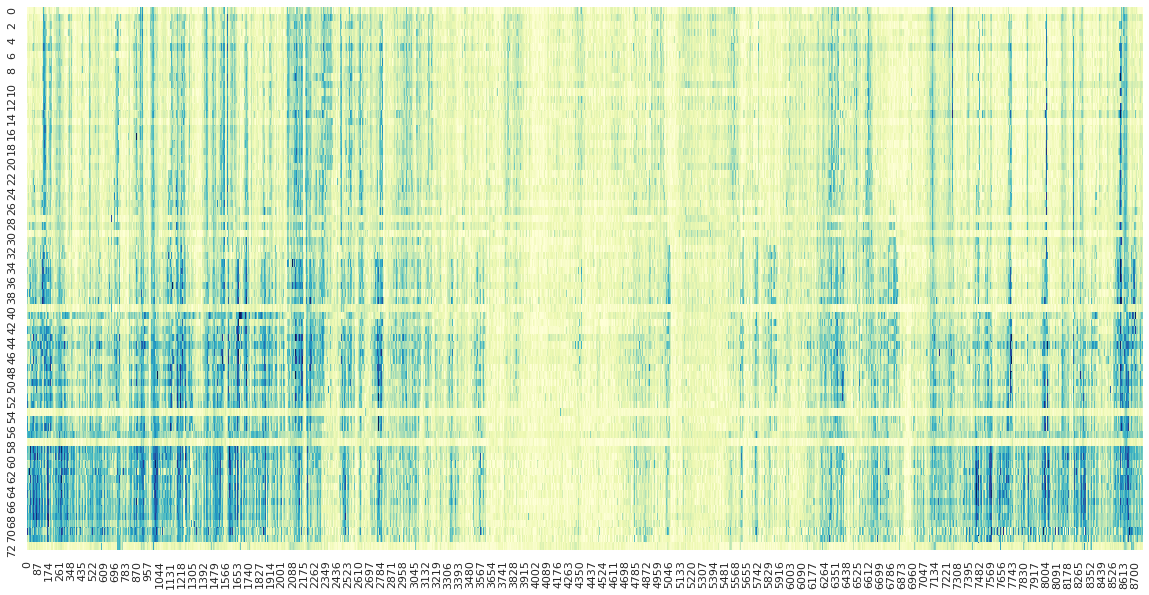

35040 43800
year: 2018


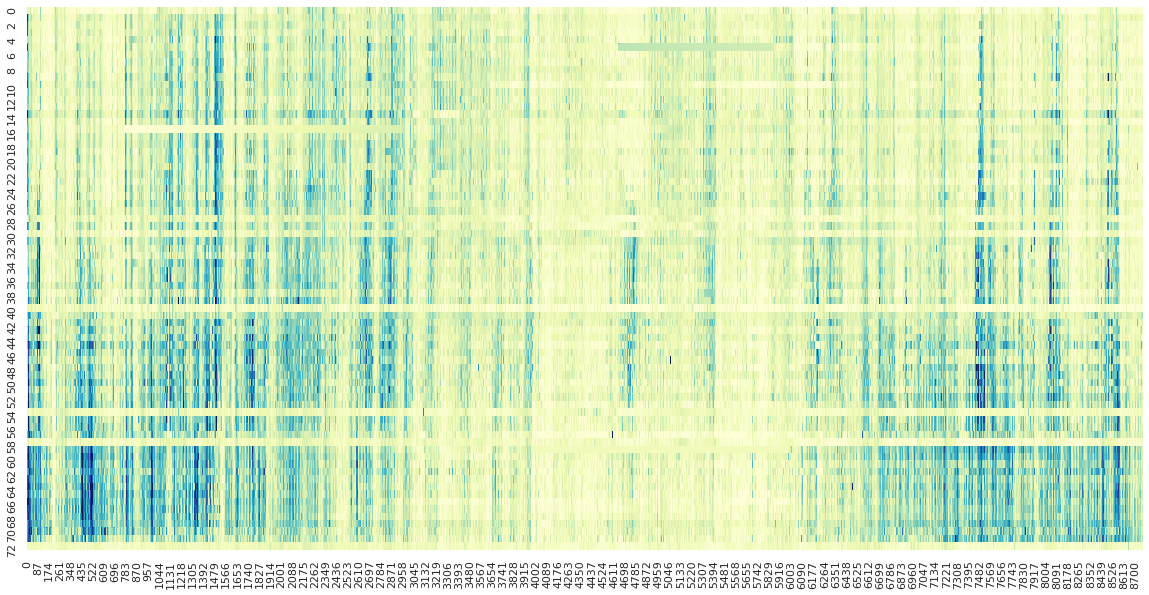

43800 52560
year: 2019


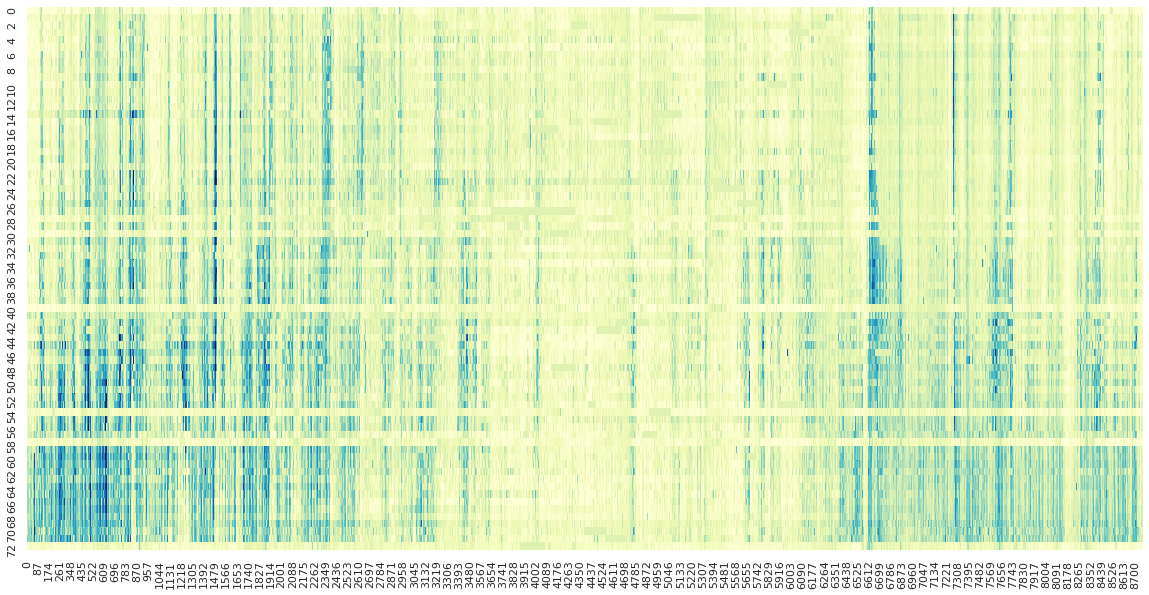

In [5]:
# draw heatmap

import plotly.graph_objects as go


sorted_sites = [
 '陽明', '萬里', '淡水', '基隆', '士林', '林口', '三重', '中山', '菜寮', '大園', '汐止', '大同', '松山', '萬華',
 '觀音', '新莊', '古亭', '永和', '板橋', '桃園', '土城', '新店', '平鎮', '中壢', '湖口', '龍潭', '新竹', '竹東',
 '宜蘭', '頭份', '冬山', '苗栗', '三義', '豐原', '沙鹿', '西屯', '忠明', '線西', '大里', '彰化', '花蓮', '埔里',
 '二林', '南投', '麥寮', '竹山', '崙背', '臺西', '斗六', '新港', '嘉義', '朴子', '新營', '善化', '關山', '安南',
 '臺南', '美濃', '臺東', '橋頭', '楠梓', '仁武', '屏東', '左營', '前金', '鳳山', '前鎮', '復興', '小港', '大寮',
 '潮州', '林園', '恆春']

# load data
origin_path = "data/origin/all"
data = []
data = np.array([np.load(os.path.join(origin_path, f"{f}.npy"))[:, 7] for f in sorted_sites])

data[data>100] = 100

for i in range(6):
    st = 24 * 365 * i
    ed = 24 * 365 * (i+1)
    print(st, ed)
    _data = data[:, st:ed]
    print(f"year: {2014+i}")
    
#     data = pd.DataFrame(data, index=sorted_sites)
    # base = datetime.fromisoformat('2014-01-01T01:00:00')
    # dates = base + np.arange(len(data)) * datetime.timedelta(hours=1)
    # fig = go.Figure(data=go.Heatmap(
    #         z=data,
    #         x=dates,
    #         y=sorted_sites,
    #         colorscale='Viridis'))

    # fig.update_layout(
    #     title='pm25 sites heatmap',
    #     xaxis_nticks=36)

    # fig.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.set(font_scale=1)
    cbar_kws = {'label': 'Christmas colorbar', 'orientation': 'horizontal'}
    ax = sns.heatmap(_data, 
                     vmin=0, 
                     vmax=100, 
                     cmap="YlGnBu", 
                     cbar=False,
                     cbar_kws=cbar_kws)
    # fig, ax = plt.subplots(figsize=(100, 80), dpi=80)
    # im = ax.imshow(data)
    # ax.set_yticks(np.arange(len(sorted_sites)))
    # ax.set_yticklabels(sorted_sites, fontsize=30)
    # fig.tight_layout()
    plt.show()


In [ ]:
# opt = parse()

no = "38"    
origin_path = "data/origin/valid"
result_path = os.path.join("test_results", no)



In [ ]:

with open("data/train_threshold.json", "r") as fp:
    thres_list = json.load(fp)

for sitename in sample_sites:
    print(f"sitename: {sitename}")
    origin_data = np.load(f"{origin_path}/{sitename}.npy")
    predict_data = np.load(f"{result_path}/{sitename}.npy")
    threshold = thres_list[sitename]

    window_size = 6570
    target = 8
    origin_data = origin_data[window_size+8-1+target:]
#     predict_data = np.expand_dims(predict_data, axis=-1)
    # create thres_data
    thres_data = np.zeros((origin_data.shape[0], 1))
    s_index = np.isin(origin_data[:, -3], [4,5,6,7,8,9])
    w_index = np.isin(origin_data[:, -3], [4,5,6,7,8,9], invert=True)
    thres_data[s_index] = threshold["summer"]
    thres_data[w_index] = threshold["winter"]
#     print(origin_data.shape, predict_data.shape)
#     print(origin_data[0, -3:])
    print(f"origin  mean ± std: {origin_data.mean():.2f} ± {origin_data.std():.2f}")
    print(f"predict mean ± std: {predict_data.mean():.2f} ± {predict_data.std():.2f}")
    st = 0
    ed = 3000 #predict_data.shape[0]
    origin_data  = origin_data [st:ed]
    predict_data = predict_data[st:ed]
    thres_data   = thres_data[st:ed]
    y = np.concatenate((origin_data[:, 7:8], predict_data[:, 0], thres_data), axis=-1)
    
    plt.figure(figsize=(50, 10))
    # TODO: the date should be customized
    st_time = f"2018-{int(origin_data[0][-3]+1)}-{int(origin_data[0][-2])} {int(origin_data[0][-1])}:00:00"
    dates = pd.date_range(st_time, periods=predict_data.shape[0], freq="H")
    data = pd.DataFrame(y, dates, columns=["origin", "predict", "threshold"])
    #sn.set_theme(style="whitegrid")

    plot = sn.lineplot(data=data, palette="tab10", linewidth=2, )
    plot.set_title(f"{sitename}", fontsize=30)
#     plot.figure.savefig(f"{save_path}/{sitename}.png")
    plt.show()
    #break


['陽明' '萬里' '淡水' '基隆' '士林' '林口' '三重' '中山' '菜寮' '大園' '汐止' '大同' '松山' '萬華'
 '觀音' '新莊' '古亭' '永和' '板橋' '桃園' '土城' '新店' '平鎮' '中壢' '湖口' '龍潭' '新竹' '竹東'
 '宜蘭' '頭份' '冬山' '苗栗' '三義' '豐原' '沙鹿' '西屯' '忠明' '線西' '大里' '彰化' '花蓮' '埔里'
 '二林' '南投' '麥寮' '竹山' '崙背' '臺西' '斗六' '新港' '嘉義' '朴子' '新營' '善化' '關山' '安南'
 '臺南' '美濃' '臺東' '橋頭' '楠梓' '仁武' '屏東' '左營' '前金' '鳳山' '前鎮' '復興' '小港' '大寮'
 '潮州' '林園' '恆春']
25.18 121.79


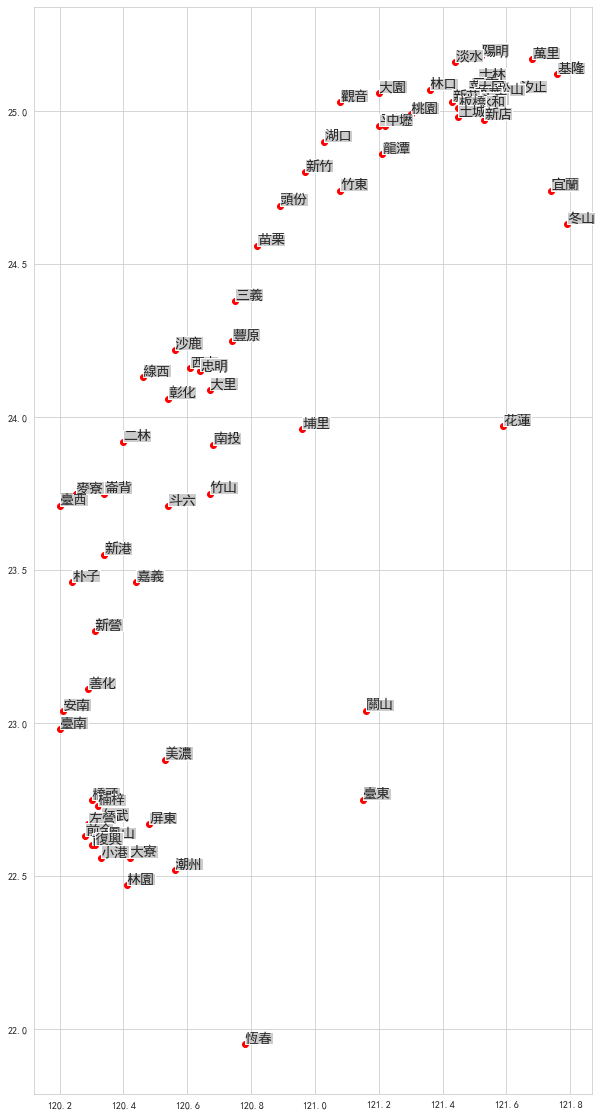

In [4]:
# plot site 2d map by gps

sitenames_sorted = sorted(sitenames)

dataset_files = ['epa_tw_14_direction.csv',
                'epa_tw_15_direction.csv',
                'epa_tw_16_direction.csv',
                'epa_tw_17_direction.csv',
                'epa_tw_18_direction.csv']

dataset_files = [f"data/{x}" for x in dataset_files]

# MARK: - Functions
def read_csv(dataset):
    data = pd.DataFrame()
    if dataset == "train":
        for d in dataset_files[:4]:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    elif dataset == "valid":
        for d in dataset_files[4:]:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    elif dataset == "all":
        for d in dataset_files:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    return data

# MARK: - Main

data = read_csv("valid")
data = data[data.sn.isin(sitenames_sorted)]
# Sort data by read_time and sitename
data = data.sort_values(['read_time', 'sn'])
# Reorder the data
data = data.reset_index(drop=True)
#gps_data = data[:len(sitenames_sorted), ["lat", "lon", "sn"]]
data = data[:len(sitenames_sorted)]
data = data[['sn', 'lat', 'lon']]
data['lat'] = pd.to_numeric(data.lat.apply(lambda x: x.replace("(", "").replace(")", "").split(",")[0]) )
data['lon'] = pd.to_numeric(data.lon.apply(lambda x: x.replace("(", "").replace(")", "").split(",")[0]) )
# data = data.sort_values(['lon'], ascending=True)
data = data.sort_values(['lat'], ascending=False)
data = data.to_numpy()
#min_lat = data[:, 1].min()
#min_lon = data[:, 2].min()
#data[:, 1] -= min_lat
#data[:, 2] -= min_lon
print(data[:, 0])
print(data[:, 1].max(), data[:, 2].max())

def addtext(ax, x, y, title, props):
    ax.text(x, y, title, props, fontsize=14)
    ax.scatter(x, y, color='r')
    ax.grid(True)

# the text bounding box
bbox = {'fc': '0.8', 'pad': 0}

fig, axs = plt.subplots(1, 1, figsize=(10, 20))

for itm in data:
    x, y = itm[2], itm[1]
    name = itm[0]
    addtext(axs, x, y, name, {'ha': 'left', 'va': 'bottom', 'bbox': bbox})
# plt.savefig('map.png')
# plt.show()

# "新莊", "板橋", "土城", "士林", "中山", "萬華", "新店", "永和", "淡水", "三重", "陽明", "大同", "松山", "古亭", "菜寮"
# "前金", "左營", "前鎮", "復興", "橋頭", "楠梓", "仁武", "小港", "鳳山"
# "林口", "桃園", "大園", "平鎮", "中壢", "龍潭"
# "苗栗", "頭份", "新竹", "湖口", "觀音", "竹東"